# Ordinary Differential Equations

In general, an ordinary differential equation looks like
\begin{equation}
f(x,g(x),g'(x),\dots, g^{(n)}(x)) = 0
\end{equation}
where $g(x)$ is the unknown.

### Trial solution
Let the trial solution be given by 
\begin{equation}
g_t(x) = h_1(x) + h_2(x,N(x,P))
\end{equation}
where $h_1(x)$ is a function that makes $g_t(x)$ satisfy a given set of conditions, $N(x,P)$ a neural network with weights and biases described by P and
$h_2(x,N(x,P))$ some expression involving the neural network.
### Cost function
\begin{equation}
c(\vec{x},P) = \frac{1}{N} \sum_{i=1}^N \left( f(x,g(x),g'(x),\dots, g^{(n)}(x)) \right)^2
\end{equation}

# Example: Exponential decay and setting up the network using Autograd
An exponential decay of a quantity is described by the equation
\begin{equation}
g'(x) = -\gamma g(x), \ \ g(0) = g_0
\end{equation}
with corresponding analytical solution 
\begin{equation}
g(x) = g_0 \exp(-\gamma x).
\end{equation}

Trial solution:
\begin{equation}
g_t(x,P) = g_0 + x \cdot N(x,P)
\end{equation}
and we have to find $P$ such that we minimize the cost function 
\begin{equation}
\text{min}_P  \frac{1}{N} \sum_{i=1}^N \left( g_t^\prime(x_i,P) - (-\gamma g_t(x_i,P)\right)^2
\end{equation}

In [16]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Assuming one input, hidden, and output layer
def neural_network(params, x):
 
    #Find the weights (including and biases) for the hidden and output layer.
    #Assume that params is a list of parameters for each layer.
    #The biases are the first element for each array in params,
    #and the weights are the remaning elements in each array in params.
    w_hidden = params[0]
    w_output = params[1]
    
    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)
    
    # Assume that the input layer does nothing to the input x
    x_input = x
    
    ## Hidden layer:
    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)
    
    z_hidden = np.dot(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)
    
    ## Output layer:
    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)
    
    z_output = np.dot(w_output, x_hidden)
    x_output = z_output
    
    return x_output

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The cost function:
def cost_function(P, x):
    
    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)
    
    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)
    
    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)
    
    # The right side of the ODE
    func = g(x, g_t)
    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)
    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases
    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )
    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included
    P = [p0, p1]
    print('Initial cost: %g'%cost_function(P, x))
    ## Start finding the optimal weights using gradient descent
    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output lay
    cost_function_grad = grad(cost_function,0)
    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad = cost_function_grad(P, x)
        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]
    print('Final cost: %g'%cost_function(P, x))
    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

In [28]:
# Set seed such that the weight are initialized
# with same weights and biases for every run.
npr.seed(15)

## Decide the vales of arguments to the function to solve
N = 10
x = np.linspace(0, 1, N)

## Set up the initial parameters
num_hidden_neurons = 10
num_iter = int(1e4)
lmb = 0.001

# Use the network
P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

# Print the deviation from the trial solution and true solution
res = g_trial(x,P)
res_analytical = g_analytic(x)
print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

Initial cost: 367.01
Final cost: 0.0666807
Max absolute difference: 0.0437499


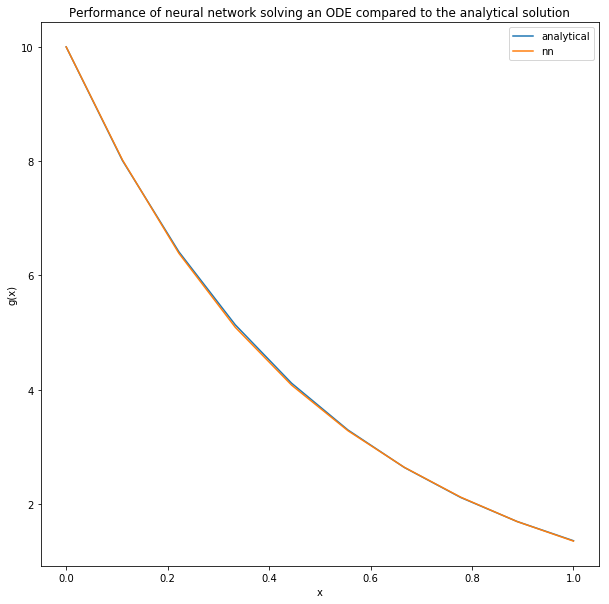

In [29]:
# Plot the results
plt.figure(figsize=(10,10))
plt.title('Performance of neural network solving an ODE compared to the analytical solution')
plt.plot(x, res_analytical)
plt.plot(x, res[0,:])
plt.legend(['analytical','nn'])
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()

# Population growth
Here, we will model a population $g(t)$ in an environment having carrying capacity
A. The population follows the model
\begin{equation}
g^\prime (t) = \alpha g(t) \left( A-g(t) \right), \ \ g(0) = g_0, \ \ \alpha > 0
\end{equation}
with corresponding analytical solution 
\begin{equation}
g(t) = \frac{Ag_0}{g_0 + (A-g_0)\exp(-\alpha At)}
\end{equation}

Trial solution: 
\begin{equation}
h_t(t) = g_0 + t \cdot N(t,P)
\end{equation}

In [34]:
#Full program modeling logistic population growth using TensorFlow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Just to reset the graph such that it is possible to rerun this in a
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()
# Set a seed to ensure getting the same results from every run
tf.set_random_seed(4155)

Nt = 10
T = 1
t = np.linspace(0,T, Nt)
## The construction phase
# Convert the values the trial solution is evaluated at to a tensor.
t_tf = tf.convert_to_tensor(t.reshape(-1,1),dtype=tf.float64)
zeros = tf.reshape(tf.convert_to_tensor(np.zeros(t.shape)),shape=(-1,1))

# Define the parameters of the equation
alpha = tf.constant(2.,dtype=tf.float64)
A = tf.constant(1.,dtype=tf.float64)
g0 = tf.constant(1.2,dtype=tf.float64)
num_iter = 100000
# Define the number of neurons at each hidden layer
num_hidden_neurons = [100,50,25]
num_hidden_layers = np.size(num_hidden_neurons)

# Construct the network.
# tf.name_scope is used to group each step in the construction,
# just for a more organized visualization in TensorBoard
with tf.name_scope('dnn'):
    # Input layer
    previous_layer = t_tf
    # Hidden layers
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1))
        previous_layer = current_layer
    # Output layer
    dnn_output = tf.layers.dense(previous_layer, 1, name='output')

# Define the cost function
with tf.name_scope('cost'):
    g_trial = g0 + t_tf*dnn_output
    d_g_trial = tf.gradients(g_trial,t_tf)
    func = alpha*g_trial*(A - g_trial)
    cost = tf.losses.mean_squared_error(zeros, d_g_trial[0] - func)
    
# Choose the method to minimize the cost function, along with a learning rate
learning_rate = 1e-2
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(cost)
    
# Set up a referance to the result from the neural network:
g_dnn_tf = None
# Define a node that initializes all of the other nodes in the computational graph
# used by TensorFlow:
init = tf.global_variables_initializer()

## Execution phase
# Start a session where the graph defined from the construction phase can be evaluated at:
with tf.Session() as sess:
    # Initialize the whole graph
    init.run()
    # Evaluate the initial cost:
    print('Initial cost: %g'%cost.eval())
    # The training of the network:
    for i in range(num_iter):
        sess.run(traning_op)
        # If one desires to see how the cost function behaves for each iteration:
        #if i % 1000 == 0:
        #    print(cost.eval())
    # Training is done, and we have an approximate solution to the ODE
    print('Final cost: %g'%cost.eval())
    # Store the result
    g_dnn_tf = g_trial.eval()

Initial cost: 0.423286
Final cost: 0.00236491


In [35]:
# Compare with analytical solution
def get_parameters():
    alpha = 2
    A = 1
    g0 = 1.2
    return alpha, A, g0

def g_analytic(t):
    alpha,A, g0 = get_parameters()
    return A*g0/(g0 + (A - g0)*np.exp(-alpha*A*t))

g_analytical = g_analytic(t)
diff_tf = g_dnn_tf - g_analytical.reshape(-1,1)

print('\nMax absolute difference between the analytical solution and solution from TensorFlow: %g' % np.max(diff_tf))


Max absolute difference between the analytical solution and solution from TensorFlow: 0.00687805


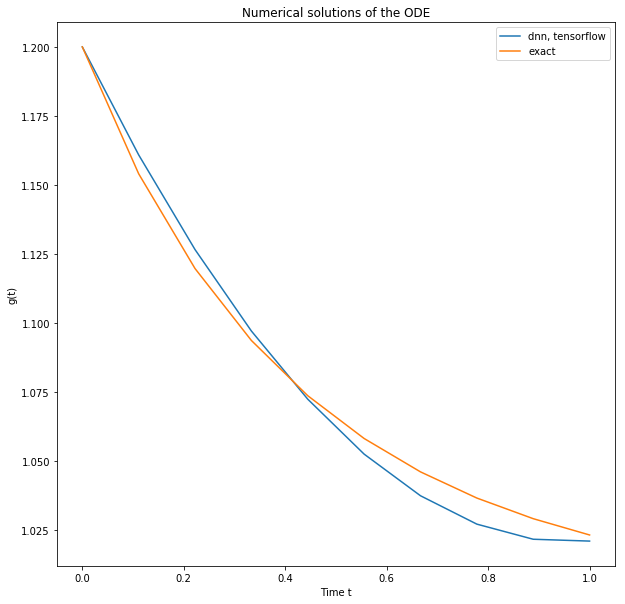

In [36]:
# Plot the result
plt.figure(figsize=(10,10))
plt.title('Numerical solutions of the ODE')
plt.plot(t, g_dnn_tf)
plt.plot(t, g_analytical)
plt.legend(['dnn, tensorflow', 'exact'])
plt.xlabel('Time t')
plt.ylabel('g(t)')
plt.show()